# 2005 UD Polarimetric Phase Curve Fitting

As a part of the publication of IshiguroM+ 2019 (in prep), here I provide full of the analysis code.

## 1. Installation

### 1-1. pymc3
On terminal (Anaconda Prompt or Git Bash on windows)
```
$ conda install pymc3 theano=1.0.4 -c conda-forge
```
See the [issue here](https://github.com/pymc-devs/pymc3/issues/3340) if you encounter problems afterwards.

## 2. Explaining Packages Used
In the code below, I used ``pymc3`` and ``scipy.optimize.curve_fit`` for the fitting algorithm. Let me briefly explain these things here.

### 2-1. ``pymc3``
The package I used for the MCMC simulation is the [``pymc3`` package](https://docs.pymc.io). Its usage is very complicated in my opinion. There are few things to keep in mind:

1. Unlike most python packages, you should work with the ``pymc3.model`` object by using the ``with`` block:
```python
basic_model = pm.Model()
with basic_model:
    # <contents goes here>
```
2. Math functions, e.g., sin/cos/exp, etc, should be used from ``pymc3.math``, not ``numpy``. You must import by ``from pymc3.math import sin, cos`` and use something like ``sin(x)`` and ``cos(x)`` inside the ``with`` block above.
3. ``pymc3`` uses ``theano``. Although it makes the calculation much faster (they argue), but it gets a bit more complicated for those who are not familiar with ``theano``. I here used it to add error-bars to data points, and you may find more examples by Googling.

### 2-2. ``scipy``'s ``curve_fit``
In the ``curve_fit`` function I used below, I tested (1) set the bounds to the parameters and (2) let them be unbounded. 

The Levenberg-Marquadt least square algorithm should not be used to bounded problem. Thus, scipy uses the _trusted region reflective_ (``trf``) algorithm. 

The explanation and implementation of it:
1. See [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares) of scipy  
2. The scipy version we used here is 1.2.1, and the ``trf`` is implemented by [``trf.py`` (GitHub link)](https://github.com/scipy/scipy/blob/v1.2.1/scipy/optimize/_lsq/trf.py). The docstring explains the implementation.

Basically it is similar to [MINPACK of FORTRAN](https://en.wikipedia.org/wiki/MINPACK), the documentation says.

### 2-3. Versions I used

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, numba, pymc3, theano, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2020-02-15 13:29:33 (KST = GMT+0900) 
0 Python     3.7.6 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    7.11.1
2 OS         Darwin 18.7.0 x86_64 i386 64bit
3 scipy      1.3.1
4 numpy      1.18.1
5 matplotlib 3.1.1
6 pandas     1.0.0
7 numba      0.47.0
8 pymc3      3.8
9 theano     1.0.4
10 version_information 1.0.3


## 3. Basic Setup

### 3-1. Import
Import necesary things:

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from pathlib import Path

import numpy as np
import numba as nb
import pandas as pd
import pymc3 as pm
from pymc3.math import sin, cos
import theano
import corner

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from scipy.optimize import curve_fit
from scipy.stats import chi2

plt.style.use('default')
rcParams.update({'font.size':12})
errbfmt = dict(marker='x', capsize=3, elinewidth=0.5, ls='')

### 3-2. Define
Define some things:

In [4]:
D2R = np.pi / 180
DATAPATH = Path('data')
SAVEPATH = Path('figs')

@nb.njit#(parallel=True)
def cos_deg(x):
    return np.cos(x * D2R)


@nb.njit#(parallel=True)
def sin_deg(x):
    return np.sin(x * D2R)


def trigp_purepython(x, h, c1, c2, a0):
    ''' Lumme-Muinonen function in pure python mode.
    '''
    term1 = (sin_deg(x) / sin_deg(a0))**c1
    term2 = (cos_deg(x / 2) / cos_deg(a0 / 2))**c2
    term3 = sin_deg(x - a0)
    Pr = h / D2R * term1 * term2 * term3
    return Pr

@nb.njit#(parallel=True)
def trigp(x, h, c1, c2, a0):
    ''' Lumme-Muinonen function in numba mode.
    '''
    term1 = (sin_deg(x) / sin_deg(a0))**c1
    term2 = (cos_deg(x / 2) / cos_deg(a0 / 2))**c2
    term3 = sin_deg(x - a0)
    Pr = h / D2R * term1 * term2 * term3
    return Pr


@nb.njit(parallel=True)
def do_trigp(x, y, yerr, arr_h, arr_c1, arr_c2, arr_a0, arr_chi2, arr_amax,
             arr_Pmax, arr_amin, arr_Pmin):
    ''' To calculate everything needed for the analysis.
    Parameters
    ----------
    x, y, yerr : array-like
        The phase angle [˚], Pr [%], and err_Pr [%].
    arr_h, arr_c1, arr_c2, arr_a0 : array-like
        The ``trace``d arrays of the four parameters of Lumme-Muinonen function
        from pymc3.
    arr_chi2, arr_amax, arr_Pmax, arr_amin, arr_Pmin : array-like
        The empty arrays of chi-square, min/max phase angle (``a``)
        and the polarization degree (``P``). Must have the same length as
        the arrays given above. (It will not give error if these are longer
        than the above ones, but...)
    '''
    xx_min = np.arange(2, 15, 0.01)
    xx_max = np.arange(80, 140, 0.01)

    for i in nb.prange(arr_h.shape[0]):
        h = arr_h[i]
        c1 = arr_c1[i]
        c2 = arr_c2[i]
        a0 = arr_a0[i]
        resid = y - trigp(x, h=h, c1=c1, c2=c2, a0=a0)
        chi2 = np.sum((resid / yerr)**2)
        amax, Pmax = trigp_max(xx_max, h=h, c1=c1, c2=c2, a0=a0)
        amin, Pmin = trigp_min(xx_min, h=h, c1=c1, c2=c2, a0=a0)

        arr_chi2[i] = chi2
        arr_amax[i] = amax
        arr_Pmax[i] = Pmax
        arr_amin[i] = amin
        arr_Pmin[i] = Pmin


@nb.njit#(parallel=True)
def trigp_min(xx, h, c1, c2, a0):
    """ Calculates the minimum phase angle/P degree from given parameters.
    """
    minimum = 1
    for i in range(xx.shape[0]):
        p = trigp(xx[i], h, c1, c2, a0)
        if p < minimum:
            minimum = p
        else:
            break
    return (xx[i - 1], minimum)


@nb.njit#(parallel=True)
def trigp_max(xx, h, c1, c2, a0):
    """ Calculates the maximum phase angle/P degree from given parameters.
    """
    maximum = -1
    for i in range(xx.shape[0]):
        p = trigp(xx[i], h, c1, c2, a0)
        if p > maximum:
            maximum = p
        else:
            break
    return (xx[i - 1], maximum)

### 3-3. Data
Now, load data and see if loaded correctly:

In [5]:
from io import StringIO
data = StringIO('''PA Pr err_Pr
68.11 23.64 3.58
63.59 19.92 1.12
55.45 12.37 1.56
46.41 11.45 11.83
33.39 4.14 0.18
29.28 2.47 0.08
25.44 1.37 0.07
11.68 -1.01 0.09
8.66 -1.25 0.08''')
dats = pd.read_csv(data, sep=' ')
dats

PA     Pr  err_Pr
0  68.11  23.64    3.58
1  63.59  19.92    1.12
2  55.45  12.37    1.56
3  46.41  11.45   11.83
4  33.39   4.14    0.18
5  29.28   2.47    0.08
6  25.44   1.37    0.07
7  11.68  -1.01    0.09
8   8.66  -1.25    0.08

If you have saved your data to the ``DATAPATH`` directory (relative path to where this notebook is located), you can use
```python
dats = pd.read_csv(DATAPATH / "weighted_avg.csv", sep=' ')
dats
```

## 4. Fit the Data!

### 4-1. Crude Scipy Fit

Before going to MCMC which will take some time and initial guess of the parameters, I here show a simple ``trf`` algorithm by scipy, which is a crude "bounded" version of Levenberg-Marquadt algorithm.

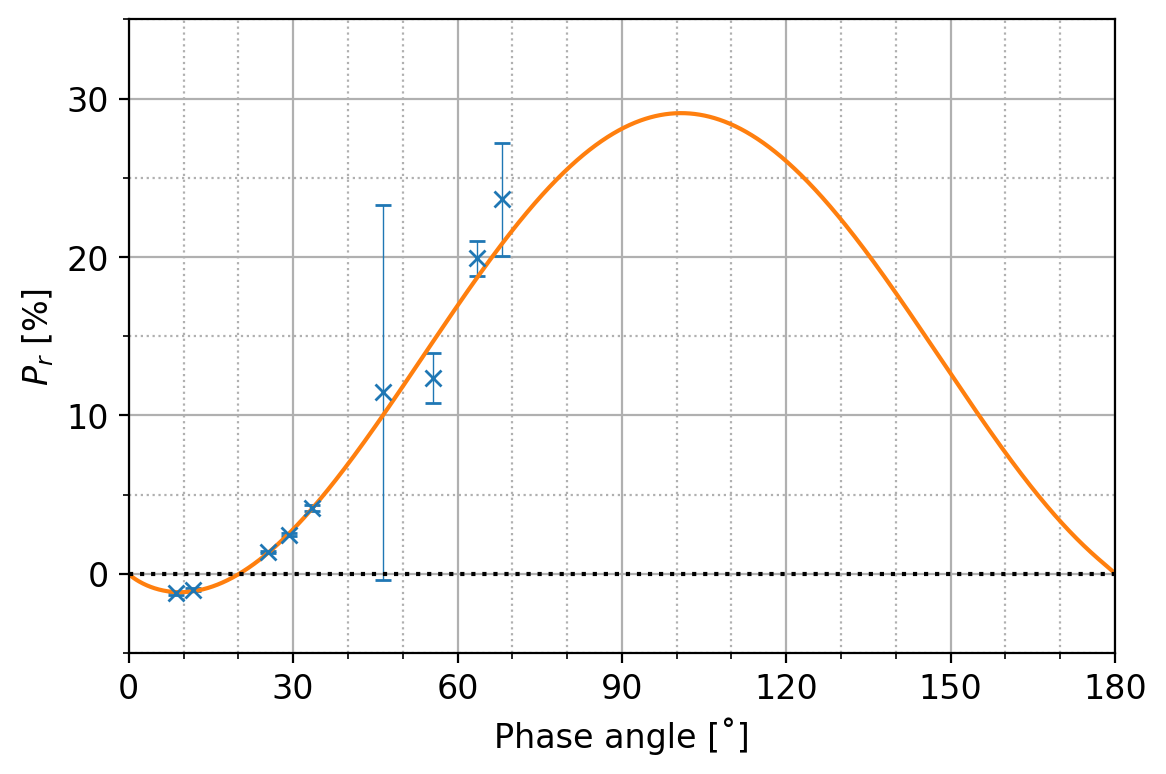

In [6]:
x, y, yerr = dats["PA"].to_numpy(), dats["Pr"].to_numpy(), dats["err_Pr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, 1.e-4, 1.e-4, 10),
                               (10.0, 10.0, 10.0, 30)))

fig, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(5)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]

ax1 = plt.subplot(1, 1, 1)
ax1.errorbar(x, y, yerr, **errbfmt)
ax1.plot(xx, trigp_purepython(xx, *popt))

ax1.set_xlabel("Phase angle [˚]")
ax1.set_ylabel(r"$ P_r $ [%]")
ax1.set_xlim(0, 180)
ax1.set_ylim(-5, 35)
ax1.axhline(0, color='k', ls=':')

for i, aa in enumerate([ax1.xaxis, ax1.yaxis]):
    aa.set_major_locator(majloc[i])
    aa.set_minor_locator(minloc[i])
    aa.set_major_formatter(majfmt[i])
ax1.grid(which='major', ls='-')
ax1.grid(which='minor', ls=':')
plt.tight_layout()

plt.savefig(SAVEPATH / "observation-fit.png")
plt.savefig(SAVEPATH / "observation-fit.pdf")

### 4-2. MCMC with ``pymc3``
Now that we got some clue about the initial parameters, do MCMC.

I assume all the parameters follow **uniform prior**, but only the lower/upper bounds of the parameters are subjectively set. 

**HERE I AM ASSUMING THE POWER PARAMETERS (C1 AND C2) ARE POSITIVE**. For non-bounded case, see section 5.

Run pymc3 for MCMC simulation:

In [7]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', 0, 1)
    a0 = pm.Uniform('a0', 10, 35)
    c1 = pm.Uniform('c1', 1.e-4, 3)
    c2 = pm.Uniform('c2', 1.e-4, 3)
#     c2 = pm.HalfNormal('c2', 0.1)

    sigma = theano.shared(np.asarray(yerr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(x * D2R) / sin(a0 * D2R))**c1 
             * (cos(x * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (x - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=y)

    trace = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:34<00:00, 2385.12draws/s]


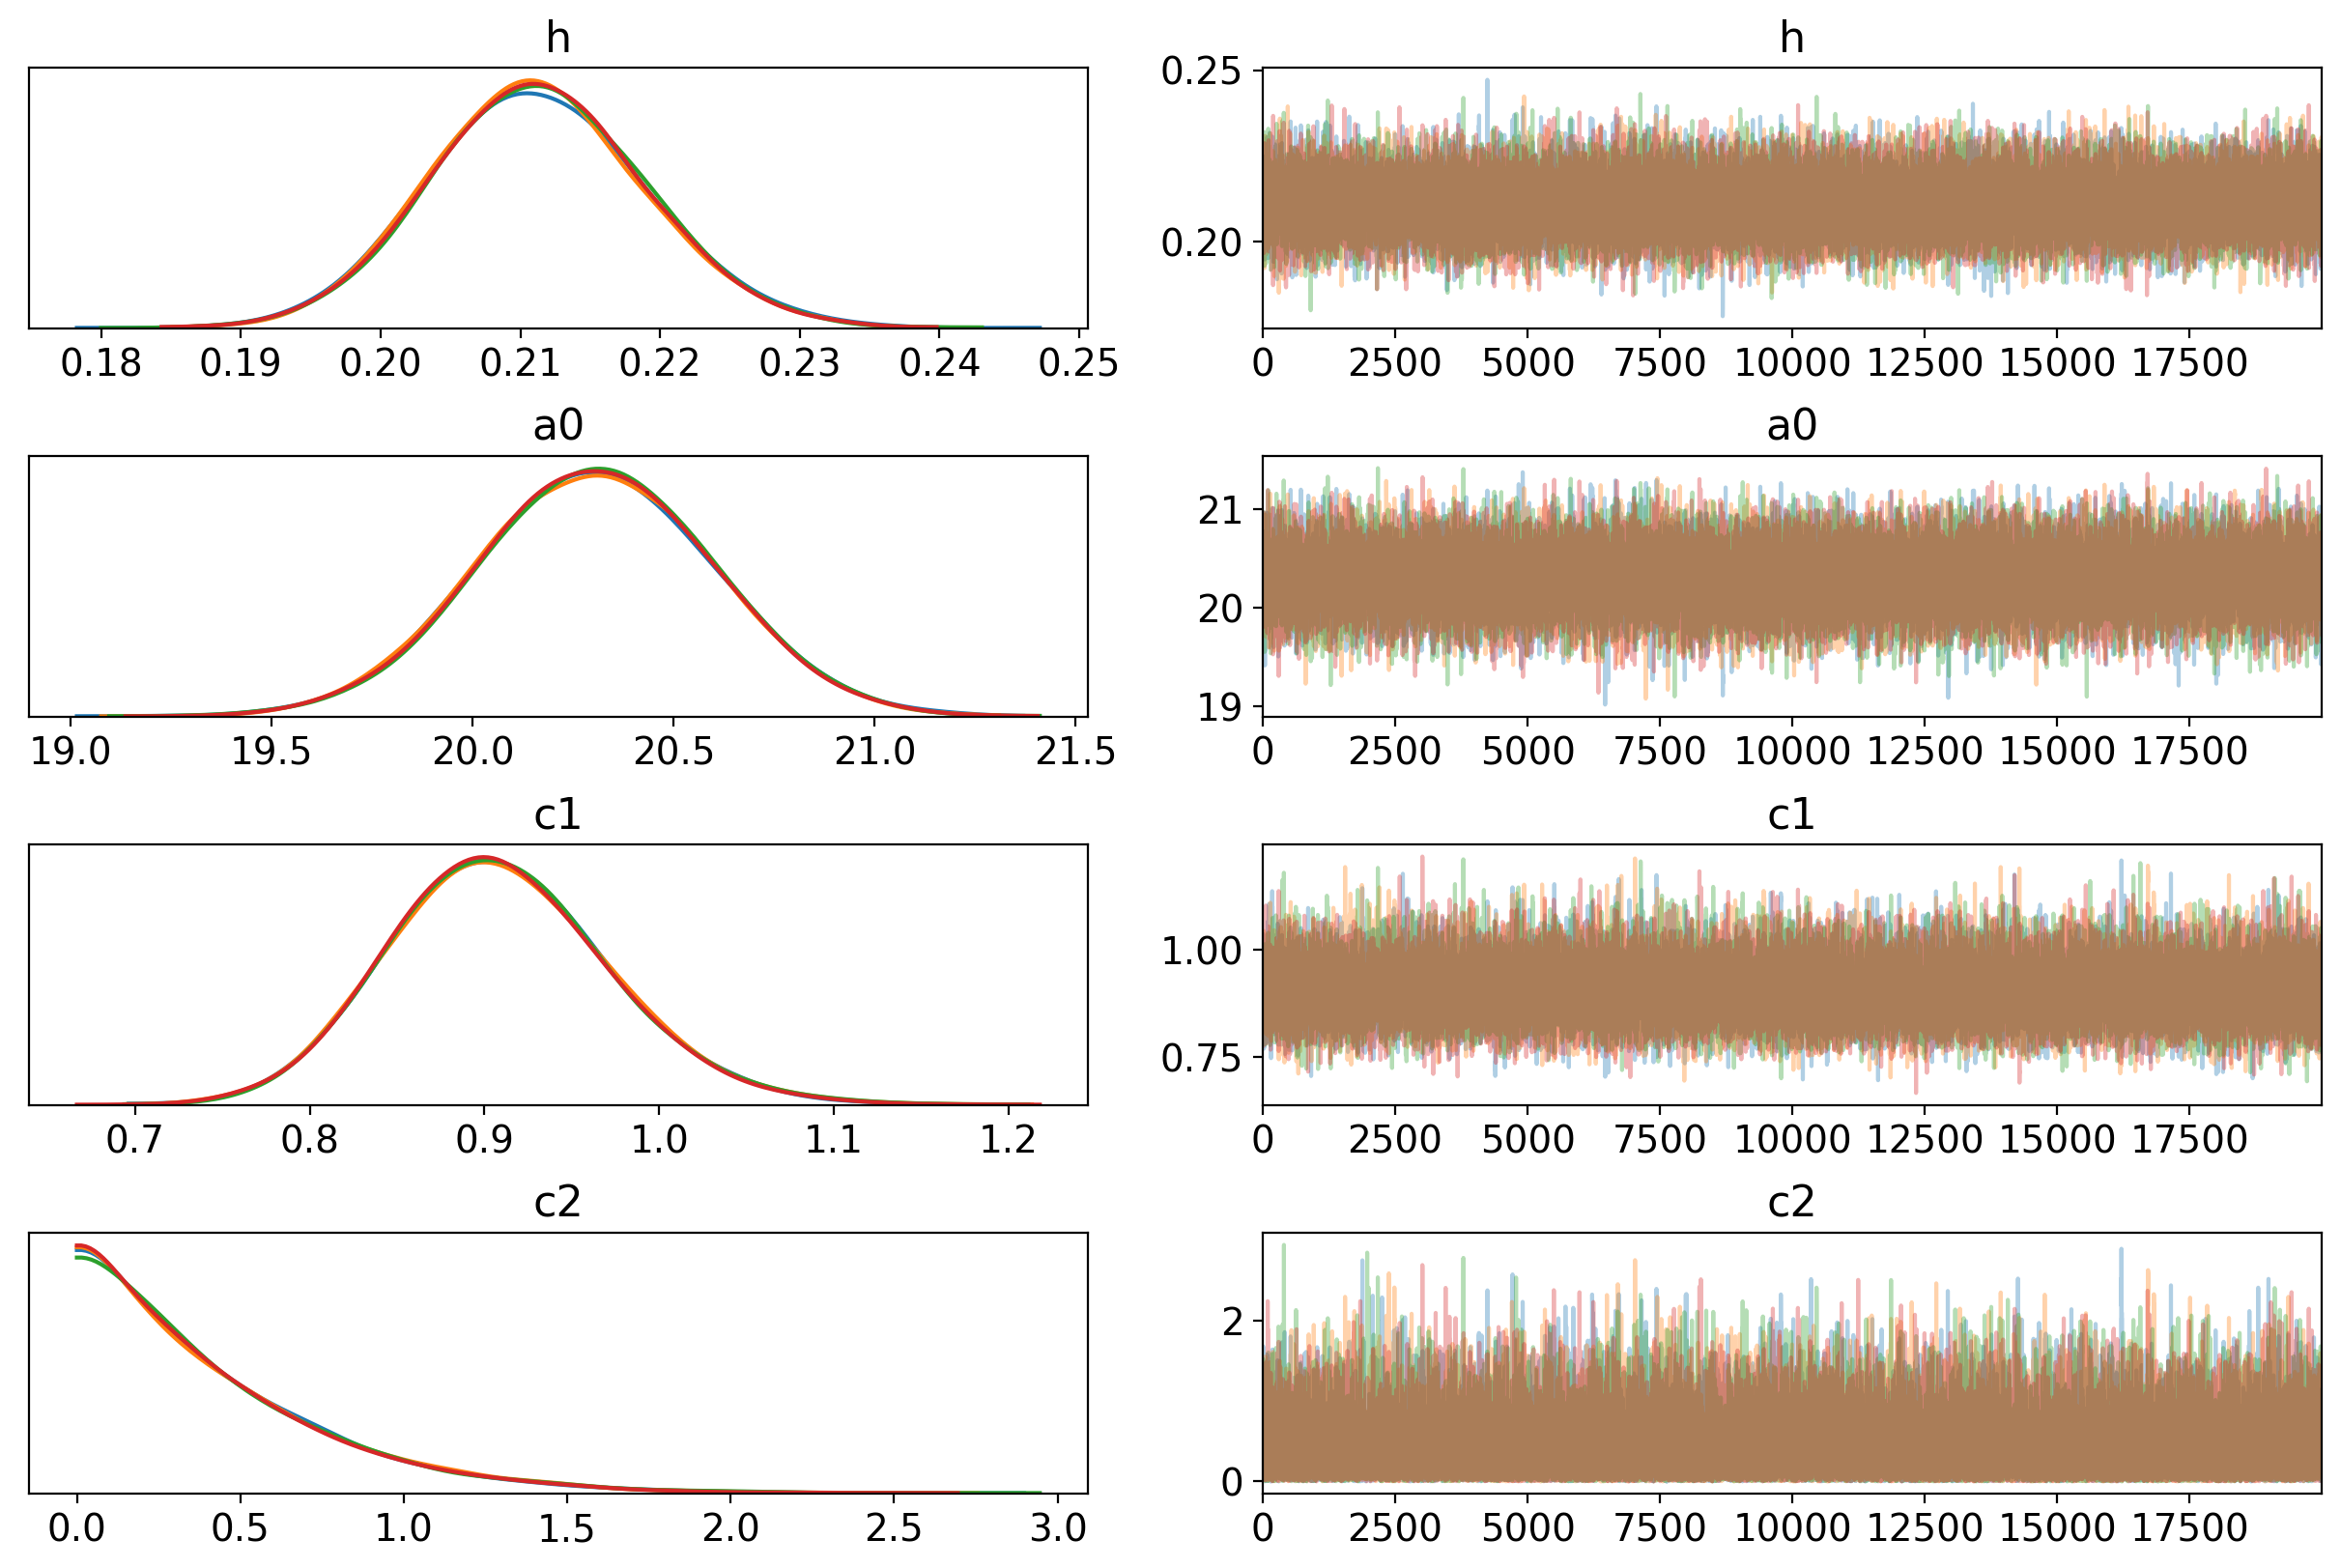

In [8]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "trace.png", dpi=300)
plt.savefig(SAVEPATH / "trace.pdf")

As can be seen, the trace looks very good except for c2. (see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect008.htm#statug.introbayes.bayesvisual))

The trace plot shows the "trace" of the Monte Carlo traces of the parameter space. Below I show the hpd (Highest Posterior Density) intervals for 1- and 3-sigma level are shown. 

In Bayesian sense, the posterior mean and standard deviation are used as parameter estimation and estimation error (e.g., see [here](https://support.sas.com/documentation/cdl/en/statug/63033/HTML/default/viewer.htm#statug_introbayes_sect005.htm#statug.introbayes.bayesinterval)), while ``mc_error`` can be understood as an uncertainty intrinsic to this simulation due to the finite number of simulations (defined as ``sd/n_eff``). This should never be understood of the parameter uncertainty.

In [9]:
pm.summary(trace, credible_interval=0.6827).round(5)

mean     sd  hpd_15.865%  hpd_84.135%  mcse_mean  mcse_sd  ess_mean  \
h    0.211  0.008        0.203        0.218      0.000    0.000   30250.0   
a0  20.301  0.290       20.008       20.587      0.002    0.001   26450.0   
c1   0.908  0.063        0.840        0.963      0.000    0.000   29582.0   
c2   0.418  0.372        0.000        0.507      0.002    0.002   29590.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
h   30087.0   30460.0   35565.0    1.0  
a0  26403.0   26446.0   33701.0    1.0  
c1  29018.0   30461.0   32637.0    1.0  
c2  29590.0   27579.0   28463.0    1.0

In summary, $ h = 0.211 \pm 0.008 \,[\%/^\circ] $ with $n_\mathrm{eff} \approx 34000$, etc, for $ \mathrm{mean \pm std} $ notation.

In [10]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

mean     sd  hpd_0.135%  hpd_99.865%  mcse_mean  mcse_sd  ess_mean  \
h    0.211  0.008       0.188        0.235      0.000    0.000   30250.0   
a0  20.301  0.290      19.424       21.163      0.002    0.001   26450.0   
c1   0.908  0.063       0.735        1.124      0.000    0.000   29582.0   
c2   0.418  0.372       0.000        1.985      0.002    0.002   29590.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
h   30087.0   30460.0   35565.0    1.0  
a0  26403.0   26446.0   33701.0    1.0  
c1  29018.0   30461.0   32637.0    1.0  
c2  29590.0   27579.0   28463.0    1.0

In [11]:
res = []
for h, a0, c1, c2 in zip(trace.get_values('h'),
                         trace.get_values('a0'),
                         trace.get_values('c1'),
                         trace.get_values('c2')):
    res.append(trigp_min(xx, h, c1, c2, a0))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 9.6441 ± 0.4281
P_min = -1.1632 ± 0.0617


### 4-3. Chi-Square Analysis
In the chi-square sense, what we have to do are
1. Calculate the chi-square statistic at each parameter space position. 
2. Keep only those with $\chi^2 < \chi^2_\mathrm{min} + \Delta(\nu, \alpha)$ 
    * $\Delta$: inverse cdf (cumulative distribution function) of $\chi^2$ distribution.
    * $\alpha$: significance level ($\alpha = 0.6827$ for 1-σ)
    * $\nu$: number of free parameters.
3. These are the models "within 1-sigma level confidence interval".
4. Get the min/max of each of the parameters and set these as lower/upper limit of the parameters.
5. The "center" of the parameters can be obtained by simple maximum likelihood estimation, such as least-square fitting.

Since it's difficult to sample all the 4-D paramter space, I used the traced parameter values from the MCMC above. 

Summarize for the models with 1-sigma chi-square value:

In [12]:
n_param = 4
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], c1=trace['c1'], c2=trace['c2'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

do_trigp(x, y, yerr, 
         arr_h=res["h"], arr_c1=res["c1"], arr_c2=res["c2"], arr_a0=res["a0"], 
         arr_chi2=res["chi2"],
         arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
         arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe()

h            c1            c2            a0          chi2  \
count  46361.000000  46361.000000  46361.000000  46361.000000  46361.000000   
mean       0.210091      0.891833      0.267196     20.259857     10.709919   
std        0.005493      0.043592      0.212292      0.213248      1.149006   
min        0.193601      0.762256      0.000103     19.605509      7.976528   
25%        0.206179      0.860950      0.093382     20.108233      9.806019   
50%        0.210167      0.892623      0.217161     20.267058     10.750592   
75%        0.214084      0.924011      0.396481     20.418701     11.665606   
max        0.223667      1.002683      1.033702     20.767820     12.695924   

               amax          amin          Pmax          Pmin  
count  46361.000000  46361.000000  46361.000000  46361.000000  
mean      96.542416      9.547935     27.093650     -1.165472  
std        3.107086      0.305388      1.741433      0.046465  
min       86.890000      8.610000     22.441251     -1.298522  
25%       94.430000      9.340000     25.842058     -1.198579  
50%       97.090000      9.560000     27.127304     -1.165147  
75%       99.140000      9.770000     28.363346     -1.132165  
max      101.280000     10.300000     32.215684     -1.038166

Only the rows of ``min`` and ``max`` are important (see below). Others are virtually meaningless.

Simple least-square fit will give the following best-fit parameters with the diagonal components as the variance of parameters when the $\chi^2$ contour are N-D ellipse:

In [13]:
popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, 
                       p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, 1.e-4, 1.e-4, 10),
                               (10.0, 10.0, 10.0, 30)))

print("Least Square Fit with Scipy curve_fit\n")
print("h[%/˚]  c1      c2      a0[˚]")
print(f"{popt[0]:.4f}  {popt[1]:.4f}  {popt[2]:.4f}  {popt[3]:.4f}\n")

print("Elliptical Approximation Errors of above")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

amin, Pmin = trigp_min(np.arange(0, 20, 0.01), *popt)
amax, Pmax = trigp_max(np.arange(80, 130, 0.01), *popt)
print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f} {Pmax:.2f}")

Least Square Fit with Scipy curve_fit

h[%/˚]  c1      c2      a0[˚]
0.2082  0.8647  0.0001  20.1849

Elliptical Approximation Errors of above
0.0107  0.1182  1.0195  0.4318

amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
9.38     -1.17    100.81 29.08


Summarize:

In [14]:
param_tab = dict(pars=["h", "c1", "c2", "a0", "amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

pars        lsqs      plus      minus       mins        maxs
0     h    0.208217  0.015450   0.014616   0.193601    0.223667
1    c1    0.864720  0.137963   0.102463   0.762256    1.002683
2    c2    0.000100  1.033602   0.000003   0.000103    1.033702
3    a0   20.184946  0.582874   0.579437  19.605509   20.767820
4  amin    9.380000  0.920000   0.770000   8.610000   10.300000
5  Pmin   -1.169186  0.131020   0.129336  -1.298522   -1.038166
6  amax  100.810000  0.470000  13.920000  86.890000  101.280000
7  Pmax   29.084190  3.131495   6.642938  22.441251   32.215684

That is, for example, $h = 0.208 ^{+0.0155}_{-0.0145} \,[\%/^\circ] $ such that the min/max are 0.194 and 0.224. (the exact value may slightly change from time to time especially the error-bars, because it's basically random sampling of finite number of samples)

Comparing the above values with the previous table's ``min`` and ``max`` of each parameter, we now have the best fit parameter and uncertainty ranges in chi-square senses.

### 4-4. Some Selected Model Plots from MCMC
Among the 80000 samples (excluding the first 2000 as burn-in phase, so that, e.g., ``len(trace.get_values['h'])`` will be 80000 not 82000), I plotted the models at every 100 index interval as black dotted line below. They're not necessarily "good" models because they are nothing but "trace".

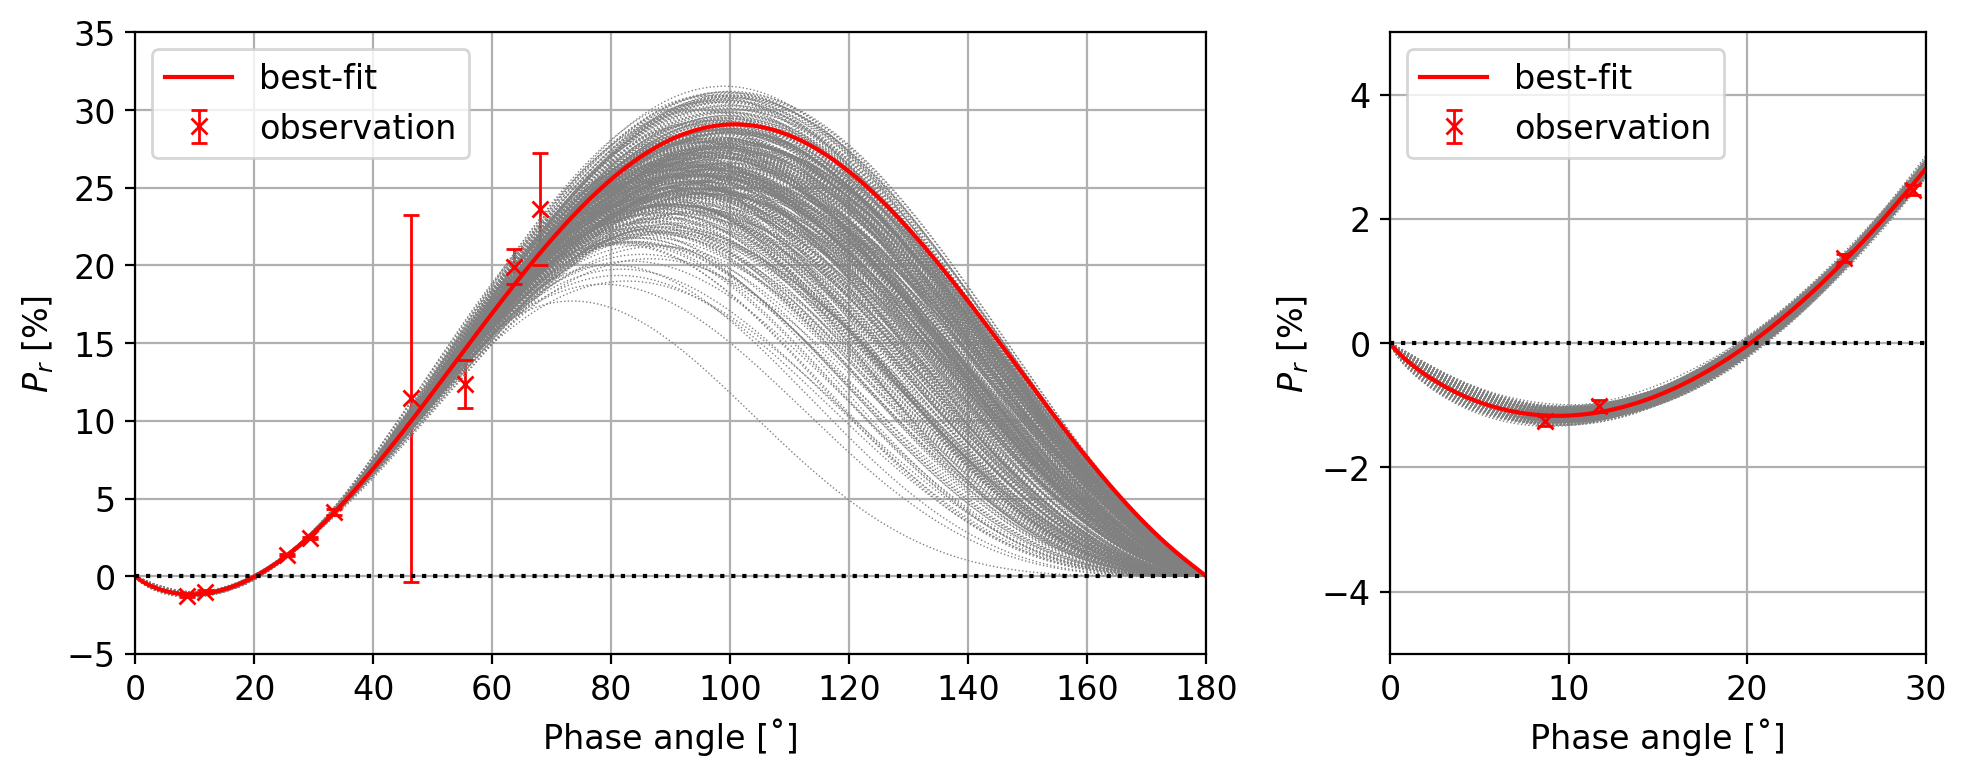

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(2)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]


for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, trigp_purepython(xx, res["h"][j], res["c1"][j], res["c2"][j], res["a0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(x, y, yerr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, trigp_purepython(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

#     for i, aa in enumerate([ax.xaxis, ax.yaxis]):
#         aa.set_major_locator(majloc[i])
#         aa.set_minor_locator(minloc[i])
#         aa.set_major_formatter(majfmt[i])
    ax.grid(which='major', ls='-')
    ax.grid(which='minor', ls=':')

axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 35)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)



plt.tight_layout()
plt.savefig(SAVEPATH / "observation-mcmc.png", dpi=300)
plt.savefig(SAVEPATH / "observation-mcmc.pdf")

### 4-5. Pairplot of Parameters

Draw a corner plot

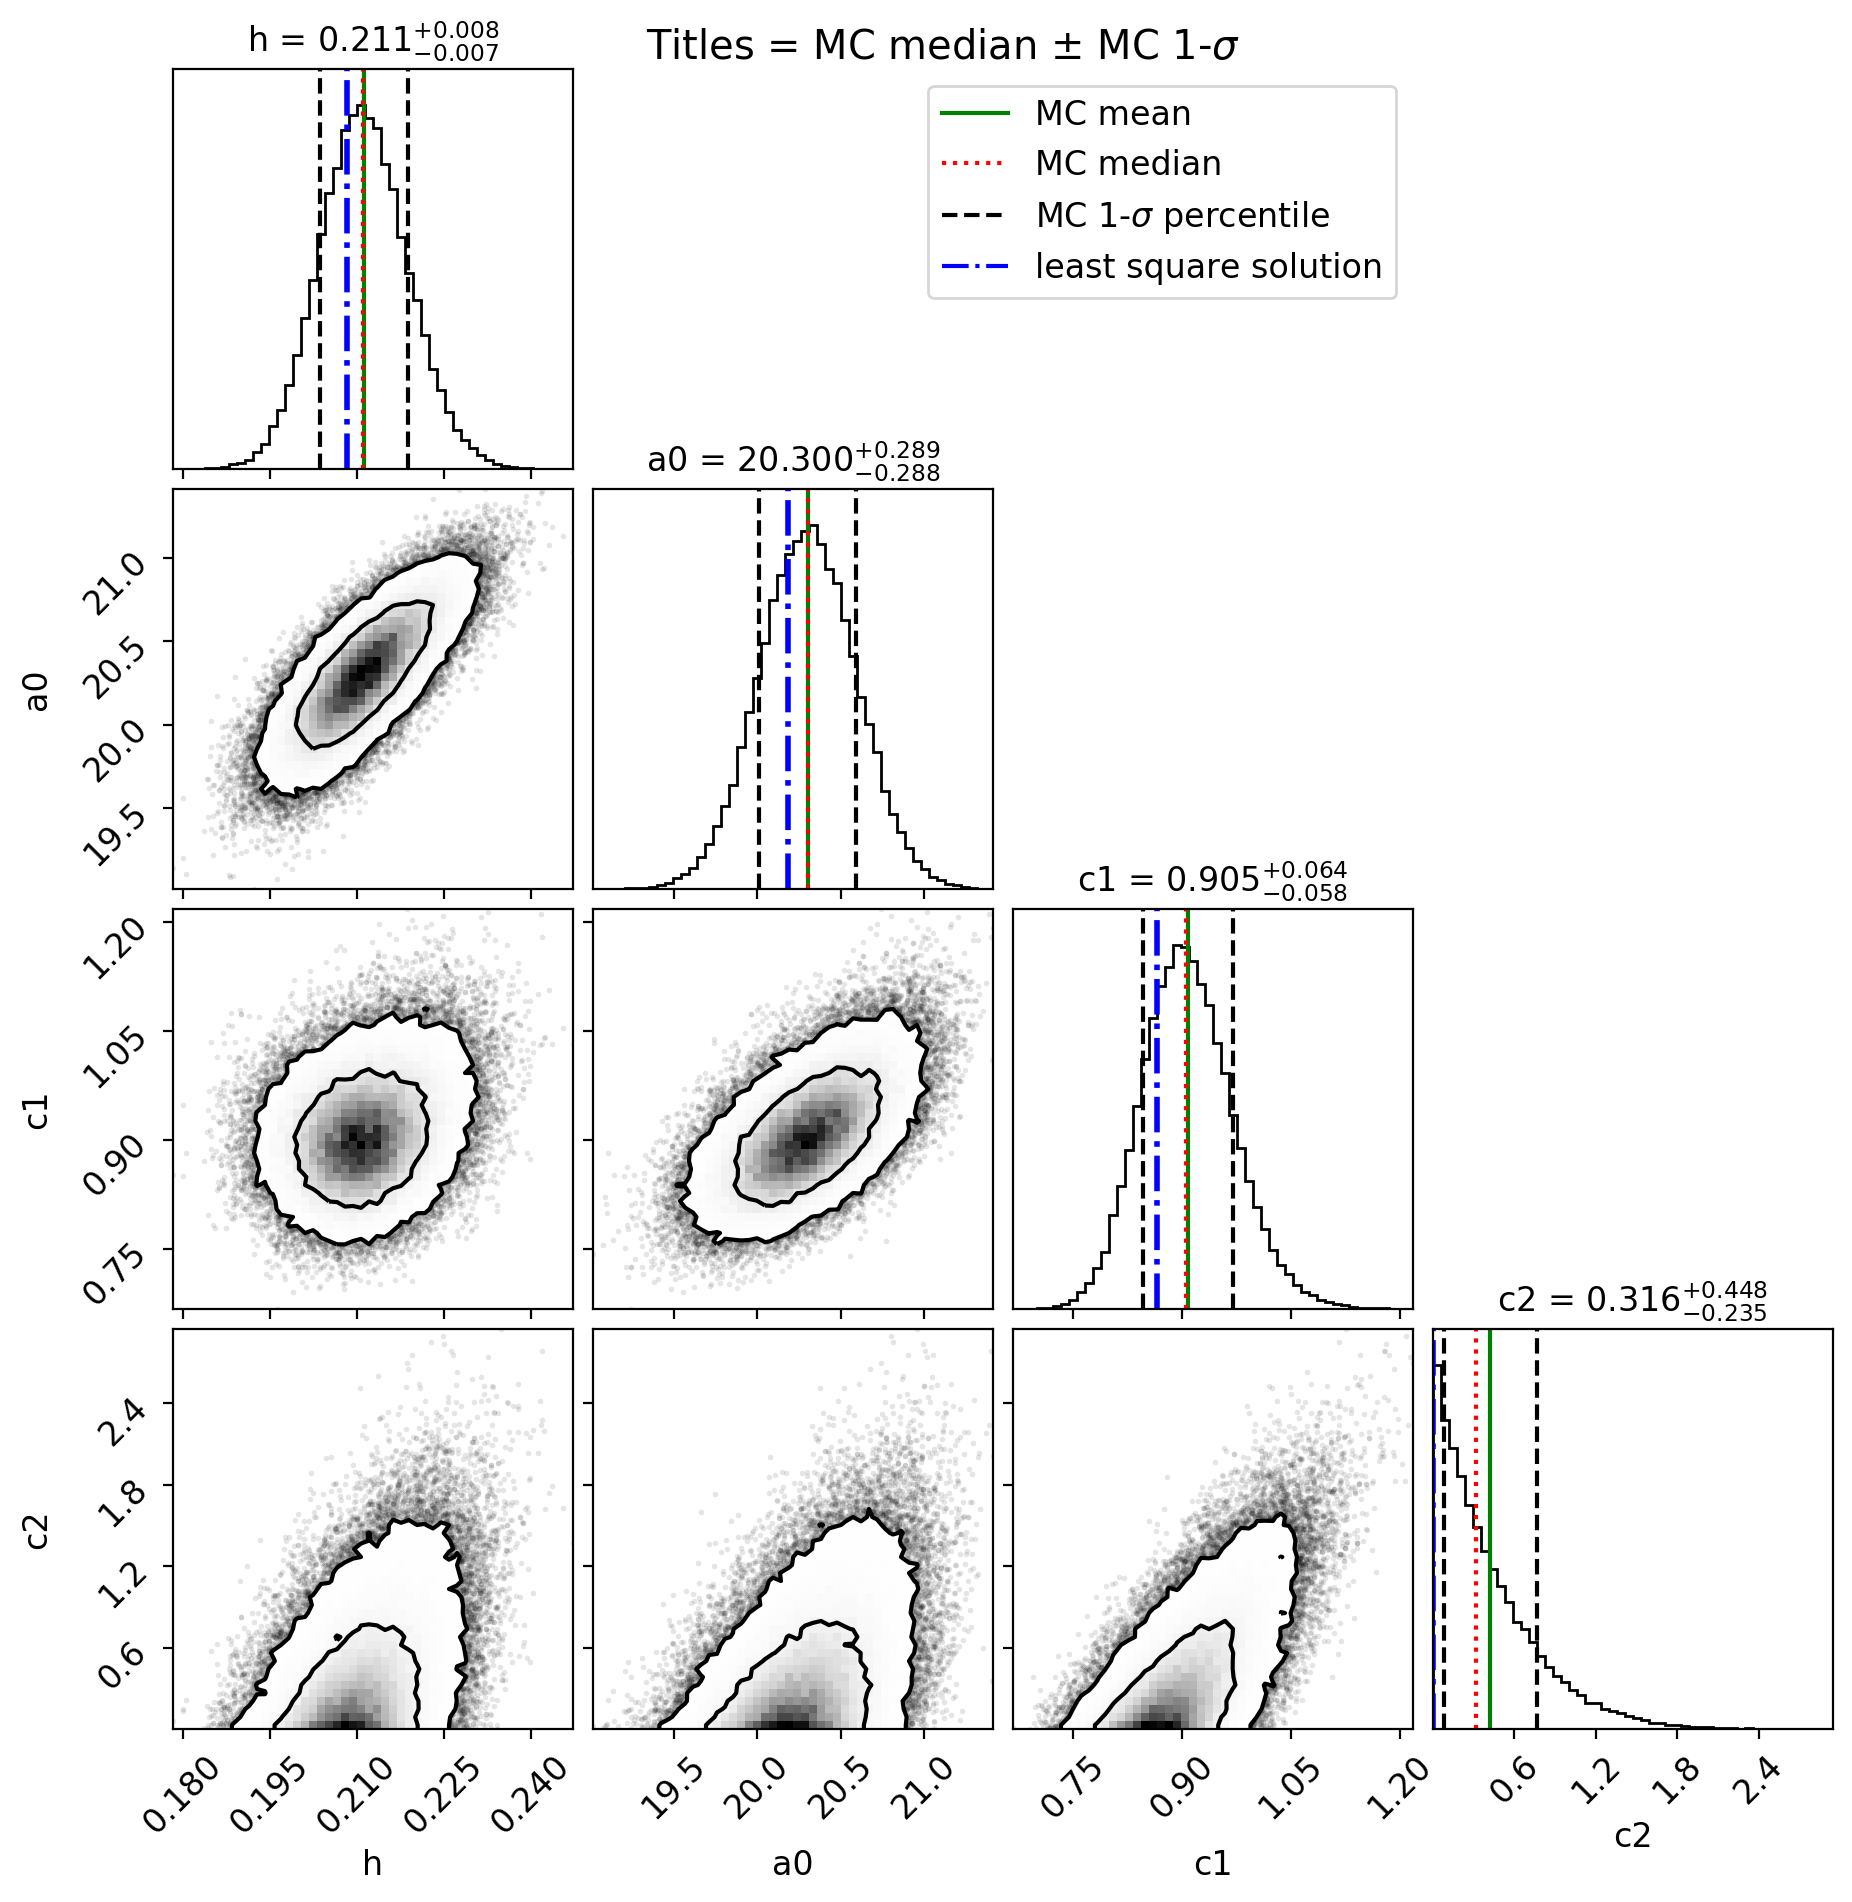

In [16]:
trace_df = pm.trace_to_dataframe(trace)
means = np.mean(trace_df, axis=0)
meds = np.median(trace_df, axis=0)
maps = np.array([popt[0], popt[3], popt[1], popt[2]])

fig = corner.corner(trace_df, 
                    quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
                    levels=[0.6827, 0.9545], #, 0.9973
                    bins=50,
                    show_titles=True,
                    title_fmt='5.3f',
                    title_kwargs={'fontsize': 12}
                   )
axes = np.array(fig.axes).reshape((4, 4))

# Loop over the diagonal
for i in range(4):
    ax = axes[i, i]
    ax.axvline(means[i], color="g", ls='-')
    ax.axvline(meds[i], color="r", ls=':')
    ax.axvline(maps[i], color='b', ls='-.', lw=2)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC median ± MC 1-$\sigma$")
plt.savefig("corner.pdf")
plt.savefig("corner.png", dpi=300)

You may use ``seaborn`` which is extremely slow in this case:
```python
trace_df = pm.trace_to_dataframe(trace)
# sns.pairplot(,
#              kind='reg', markers='+')

g = sns.PairGrid(trace_df, diag_sharey=False)
g.map_lower(sns.kdeplot, kind='reg')
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)
```

### 4-6. To LATEX Table
If you want to save the resulting table as LaTeX format, for example, you may use the following python code:

In [17]:
from astropy.io.ascii.latex import latexdicts
from astropy.table import Table, vstack

tab = Table.from_pandas(param_tab)

for c in tab.colnames:
    try:    
        tab[c].format = '.4f'
    except ValueError:
        continue

tab.write(SAVEPATH / "test.tex", format='ascii.latex', latexdict=latexdicts["AA"])

``latexdicts["AA"]`` means it is in the format of A&A. You may use ``"AA"``, ``"doublelines"``, and ``"template"``.

It has the following output:

```latex
\begin{table}
\begin{tabular}{cccccc}
\hline \hline
pars & lsqs & plus & minus & mins & maxs \\
\hline
h & 0.2082 & 0.0178 & 0.0157 & 0.1925 & 0.2261 \\
c1 & 0.8647 & 0.1625 & 0.1120 & 0.7527 & 1.0273 \\
c2 & 0.0001 & 1.2607 & 0.0000 & 0.0001 & 1.2608 \\
a0 & 20.1849 & 0.6554 & 0.6485 & 19.5364 & 20.8404 \\
amin & 9.3800 & 1.0600 & 0.9000 & 8.4800 & 10.4400 \\
Pmin & -1.1692 & 0.1446 & 0.1485 & -1.3176 & -1.0246 \\
amax & 100.8100 & 0.5500 & 16.0500 & 84.7600 & 101.3600 \\
Pmax & 29.0842 & 3.4382 & 7.5246 & 21.5596 & 32.5224 \\
\hline
\end{tabular}
\end{table}
```

You may tune it as you wish...

## 5. What if no bound for powers?

In [18]:
basic_model = pm.Model()
with basic_model:
    h = pm.Uniform('h', 0, 1)
    a0 = pm.Uniform('a0', 10, 35)
    c1 = pm.Uniform('c1', -10, 10)
    c2 = pm.Uniform('c2', -10, 10)

    sigma = theano.shared(np.asarray(yerr, dtype=theano.config.floatX), name='sigma')

    Y_hat = (h / D2R 
             * (sin(x * D2R) / sin(a0 * D2R))**c1 
             * (cos(x * D2R / 2) / cos(a0 * D2R / 2))**c2 
             * sin( (x - a0) * D2R)
            )
    liklihood = pm.Normal('likelihood', mu=Y_hat, sd=sigma, observed=y)

    trace = pm.sample(20000, start=dict(h=0.1, a0=20, c1=0.1, c2=1.e-3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c2, c1, a0, h]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:46<00:00, 1753.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


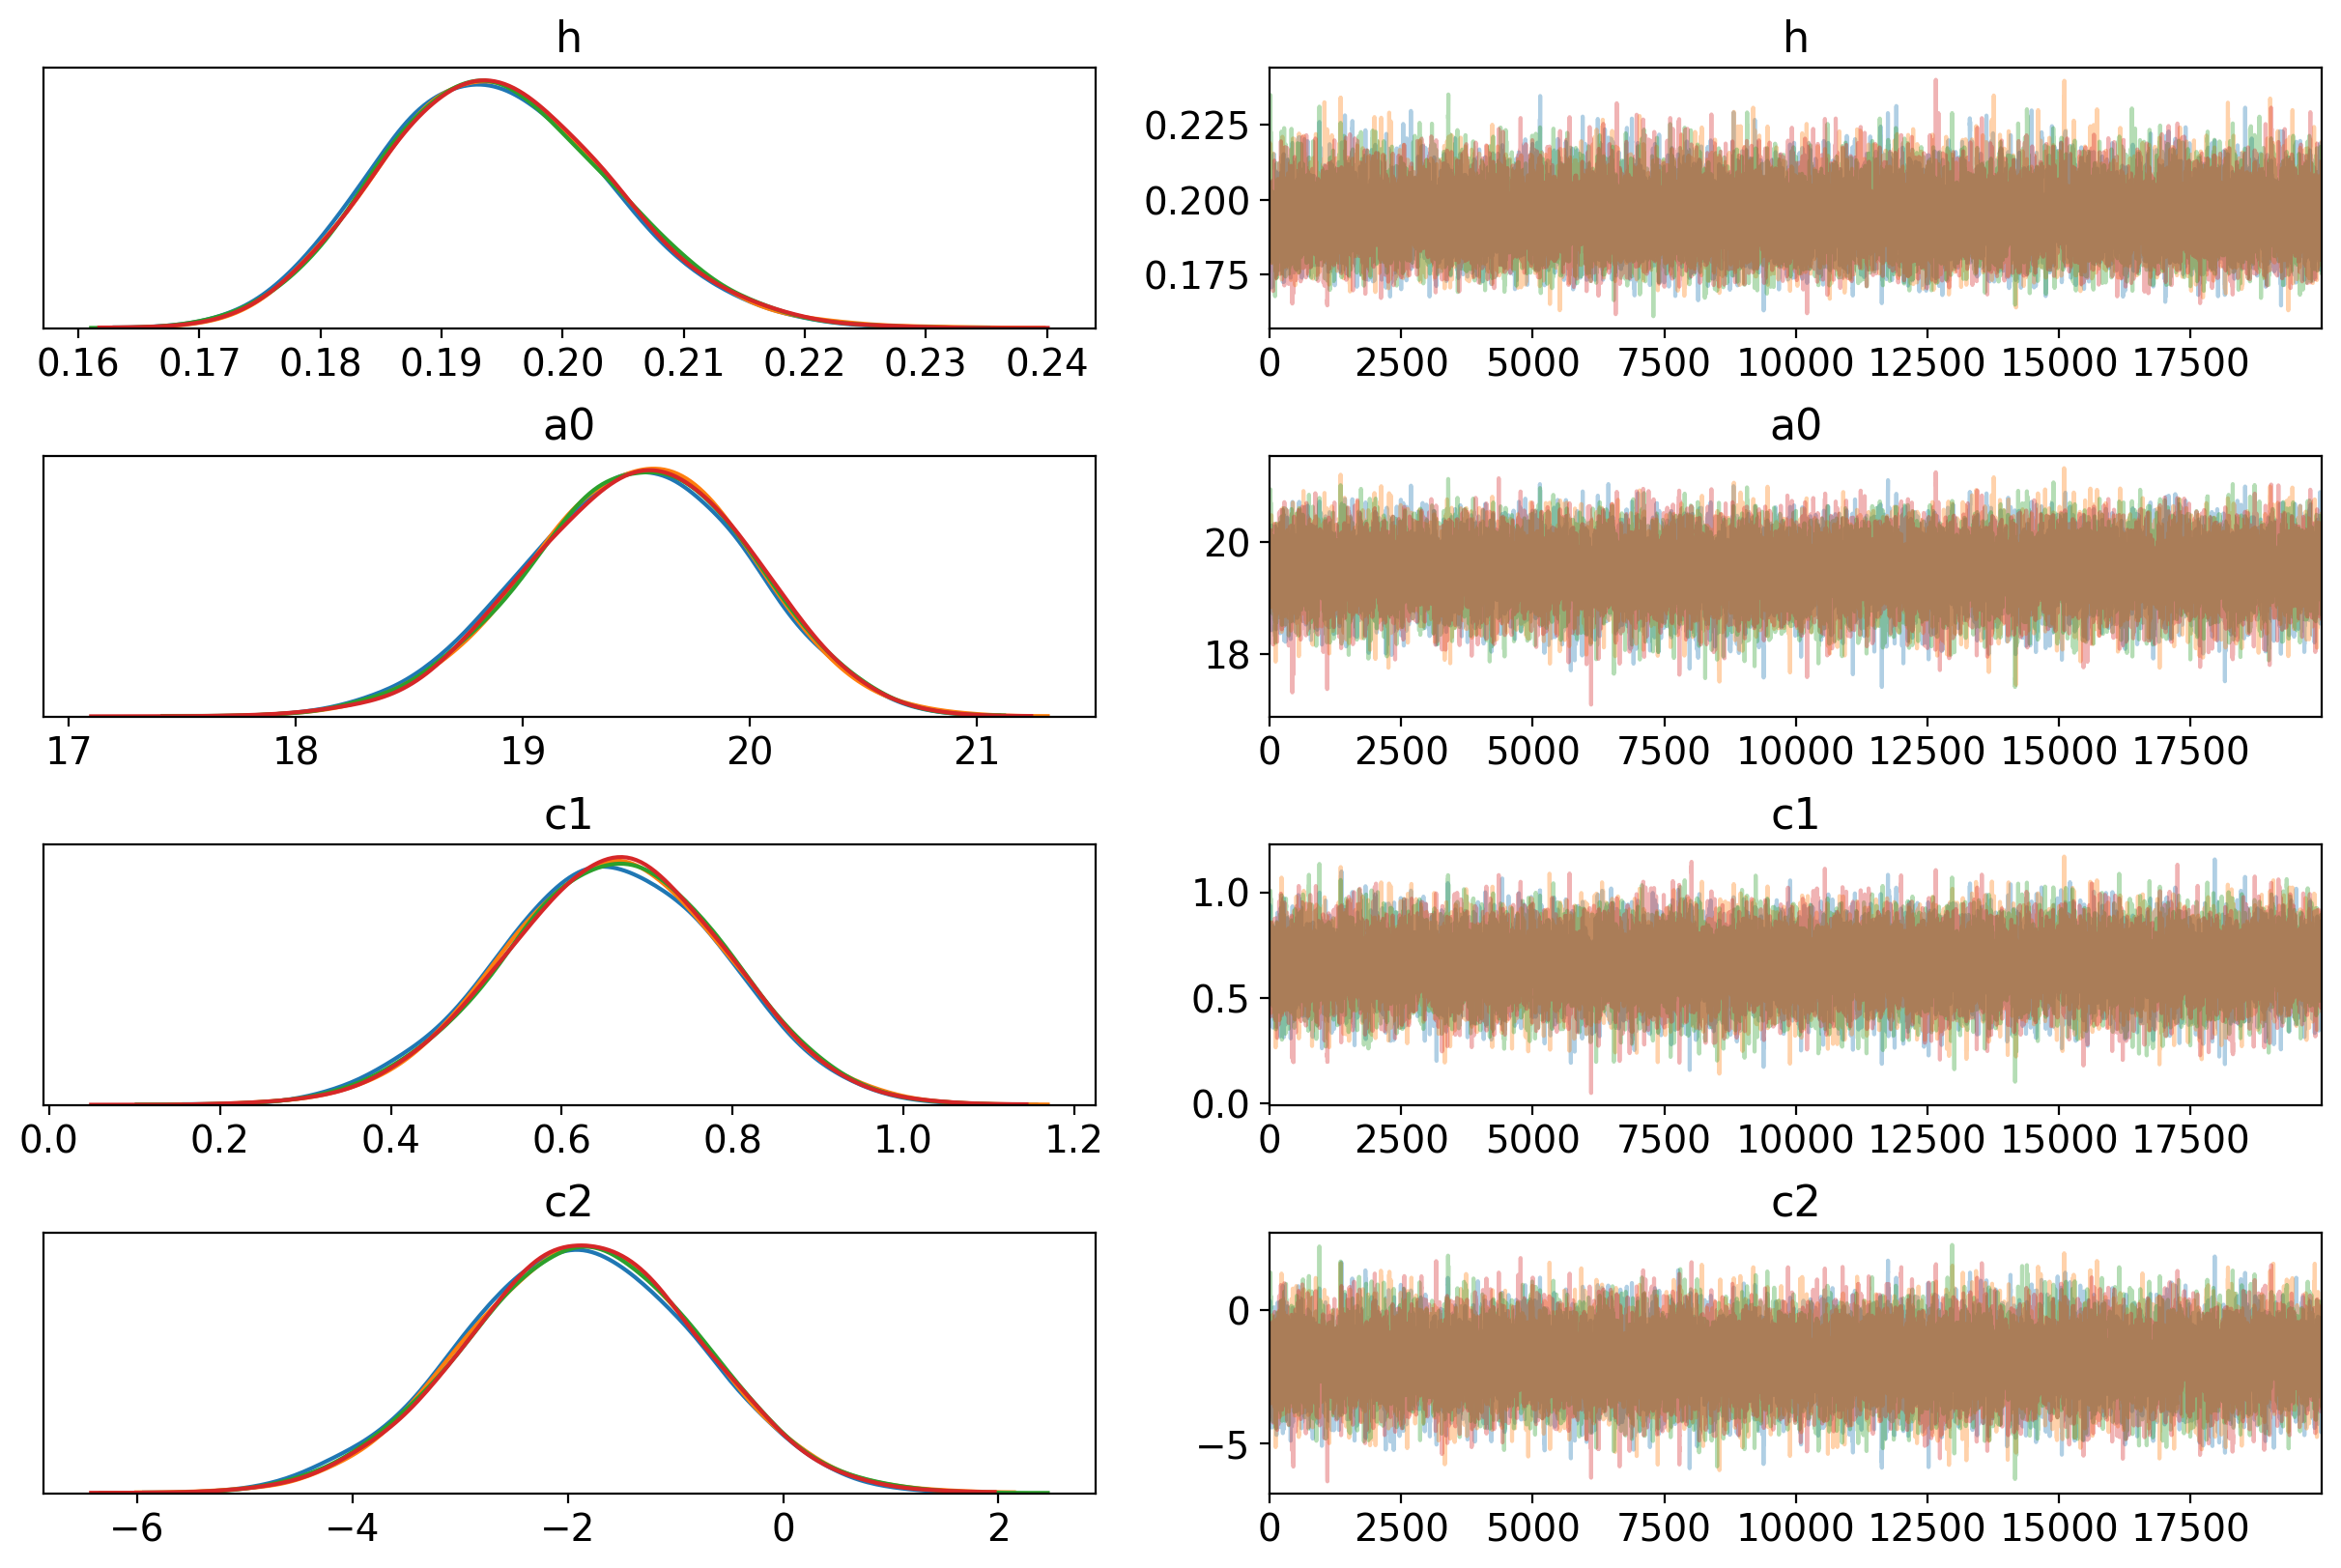

In [19]:
pm.traceplot(trace)
plt.savefig(SAVEPATH / "trace-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "trace-nobound.pdf")

In [20]:
pm.summary(trace, credible_interval=0.6827).round(5)

mean     sd  hpd_15.865%  hpd_84.135%  mcse_mean  mcse_sd  ess_mean  \
h    0.194  0.009        0.184        0.203      0.000    0.000   17181.0   
a0  19.495  0.487       19.030       20.003      0.004    0.003   15697.0   
c1   0.656  0.129        0.534        0.792      0.001    0.001   15948.0   
c2  -1.901  1.075       -2.959       -0.809      0.009    0.006   15930.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
h   17171.0   17181.0   23953.0    1.0  
a0  15697.0   15723.0   20978.0    1.0  
c1  15948.0   15967.0   21425.0    1.0  
c2  15865.0   15935.0   21862.0    1.0

In [21]:
pm.summary(trace, credible_interval=0.9973).round(5)  # 3-sigma

mean     sd  hpd_0.135%  hpd_99.865%  mcse_mean  mcse_sd  ess_mean  \
h    0.194  0.009       0.168        0.225      0.000    0.000   17181.0   
a0  19.495  0.487      17.970       20.871      0.004    0.003   15697.0   
c1   0.656  0.129       0.252        1.027      0.001    0.001   15948.0   
c2  -1.901  1.075      -5.143        1.288      0.009    0.006   15930.0   

     ess_sd  ess_bulk  ess_tail  r_hat  
h   17171.0   17181.0   23953.0    1.0  
a0  15697.0   15723.0   20978.0    1.0  
c1  15948.0   15967.0   21425.0    1.0  
c2  15865.0   15935.0   21862.0    1.0

In [22]:
res = []
for h, a0, c1, c2 in zip(trace.get_values('h'),
                         trace.get_values('a0'),
                         trace.get_values('c1'),
                         trace.get_values('c2')):
    res.append(trigp_min(xx, h, c1, c2, a0))
res = np.array(res)
amin_mean, pmin_mean = np.mean(res, axis=0)
amin_sd, pmin_sd = np.std(res, axis=0, ddof=1)
print(f"a_min = {amin_mean:.4f} ± {amin_sd:.4f}")
print(f"P_min = {pmin_mean:.4f} ± {pmin_sd:.4f}")

a_min = 7.7641 ± 1.0759
P_min = -1.2335 ± 0.0899


In [23]:
n_param = 4
delta = chi2.ppf(0.6827, n_param)

n_trace = trace['h'].shape[0]
res = dict(h=trace['h'], c1=trace['c1'], c2=trace['c2'], a0=trace['a0'],
           chi2=np.zeros(n_trace),
           amax=np.zeros(n_trace), amin=np.zeros(n_trace),
           Pmax=np.zeros(n_trace), Pmin=np.zeros(n_trace))

do_trigp(x, y, yerr, 
         arr_h=res["h"], arr_c1=res["c1"], arr_c2=res["c2"], arr_a0=res["a0"], 
         arr_chi2=res["chi2"],
         arr_amax=res["amax"], arr_Pmax=res["Pmax"], 
         arr_amin=res["amin"], arr_Pmin=res["Pmin"])

chi2_min = res["chi2"].min()
mask_1sig = res["chi2"] < (chi2_min + delta)
# mask_1sig = res["chi2"] < (chi2_min + np.sqrt(2/(y.shape[0]-4)))

res_df = pd.DataFrame(res)
res_1sig = res_df[mask_1sig]

res_1sig.describe()

h            c1            c2            a0          chi2  \
count  53978.000000  53978.000000  53978.000000  53978.000000  53978.000000   
mean       0.194375      0.657286     -1.901325     19.506088      7.086977   
std        0.007405      0.100592      0.838769      0.379739      1.198800   
min        0.176007      0.375905     -4.208633     18.441392      4.616896   
25%        0.188839      0.585149     -2.509264     19.233831      6.115105   
50%        0.194122      0.658341     -1.897256     19.514539      7.056846   
75%        0.199656      0.730951     -1.290784     19.787013      8.053698   
max        0.216172      0.921115      0.333893     20.492479      9.336421   

               amax          amin          Pmax          Pmin  
count  53978.000000  53978.000000  53978.000000  53978.000000  
mean     136.470614      7.800041    151.940916     -1.228013  
std        8.796854      0.827681    128.928157      0.066651  
min       95.330000      5.200000     26.388029     -1.452665  
25%      139.980000      7.230000     61.315437     -1.272813  
50%      139.980000      7.850000    109.905566     -1.223563  
75%      139.980000      8.420000    197.321658     -1.179293  
max      139.980000      9.770000   1009.053679     -1.067358

In [24]:
x, y, yerr = dats["PA"].to_numpy(), dats["Pr"].to_numpy(), dats["err_Pr"].to_numpy()
x_rad = D2R * x
xx = np.arange(0.1, 180, 0.1)

popt, pcov = curve_fit(trigp_purepython, x, y, sigma=yerr, 
                       p0=[1, 1, 1, 20],
                       absolute_sigma=True,
                       bounds=((0.01, -10., -10., 10),
                               (10.0, 10.0, 10.0, 30)))
print("Least Square Fit with Scipy curve_fit\n")
print("h[%/˚]  c1      c2      a0[˚]")
print(f"{popt[0]:.4f}  {popt[1]:.4f}  {popt[2]:.4f}  {popt[3]:.4f}\n")

print("Elliptical Approximation Errors of above")
print("{:.4f}  {:.4f}  {:.4f}  {:.4f}\n".format(*np.sqrt(np.diag(pcov))))

amin, Pmin = trigp_min(np.arange(0, 20, 0.01), *popt)
amax, Pmax = trigp_max(np.arange(80, 130, 0.01), *popt)
print("amin[˚]  Pmin[%]  amax[˚]  Pmax[%]")
print(f"{amin:.2f}     {Pmin:.2f}    {amax:.2f} {Pmax:.2f}")

Least Square Fit with Scipy curve_fit

h[%/˚]  c1      c2      a0[˚]
0.1942  0.6564  -1.9193  19.5151

Elliptical Approximation Errors of above
0.0092  0.1239  1.0342  0.4711

amin[˚]  Pmin[%]  amax[˚]  Pmax[%]
7.83     -1.22    129.98 91.26


In [25]:
param_tab = dict(pars=["h", "c1", "c2", "a0", "amin", "Pmin", "amax", "Pmax"],
                 lsqs=[*popt, amin, Pmin, amax, Pmax],  # least-square solution
                 plus=[], minus=[],  # mins/maxs in lsqs +/- sense
                 mins=[], maxs=[]    # min/max of 1-sigma range
                )
for i, p in enumerate(param_tab["pars"]):
    pmin = res_1sig[p].min()
    pmax = res_1sig[p].max()
    p_hi = abs(pmax - param_tab["lsqs"][i])
    p_lo = abs(param_tab["lsqs"][i] - pmin)
    
    param_tab["mins"].append(pmin)
    param_tab["maxs"].append(pmax)
    param_tab["plus"].append(p_hi)
    param_tab["minus"].append(p_lo)
    
param_tab = pd.DataFrame.from_dict(param_tab)
param_tab

pars        lsqs        plus      minus       mins         maxs
0     h    0.194197    0.021975   0.018190   0.176007     0.216172
1    c1    0.656409    0.264706   0.280504   0.375905     0.921115
2    c2   -1.919324    2.253217   2.289309  -4.208633     0.333893
3    a0   19.515136    0.977343   1.073744  18.441392    20.492479
4  amin    7.830000    1.940000   2.630000   5.200000     9.770000
5  Pmin   -1.221717    0.154359   0.230948  -1.452665    -1.067358
6  amax  129.980000   10.000000  34.650000  95.330000   139.980000
7  Pmax   91.260627  917.793052  64.872598  26.388029  1009.053679

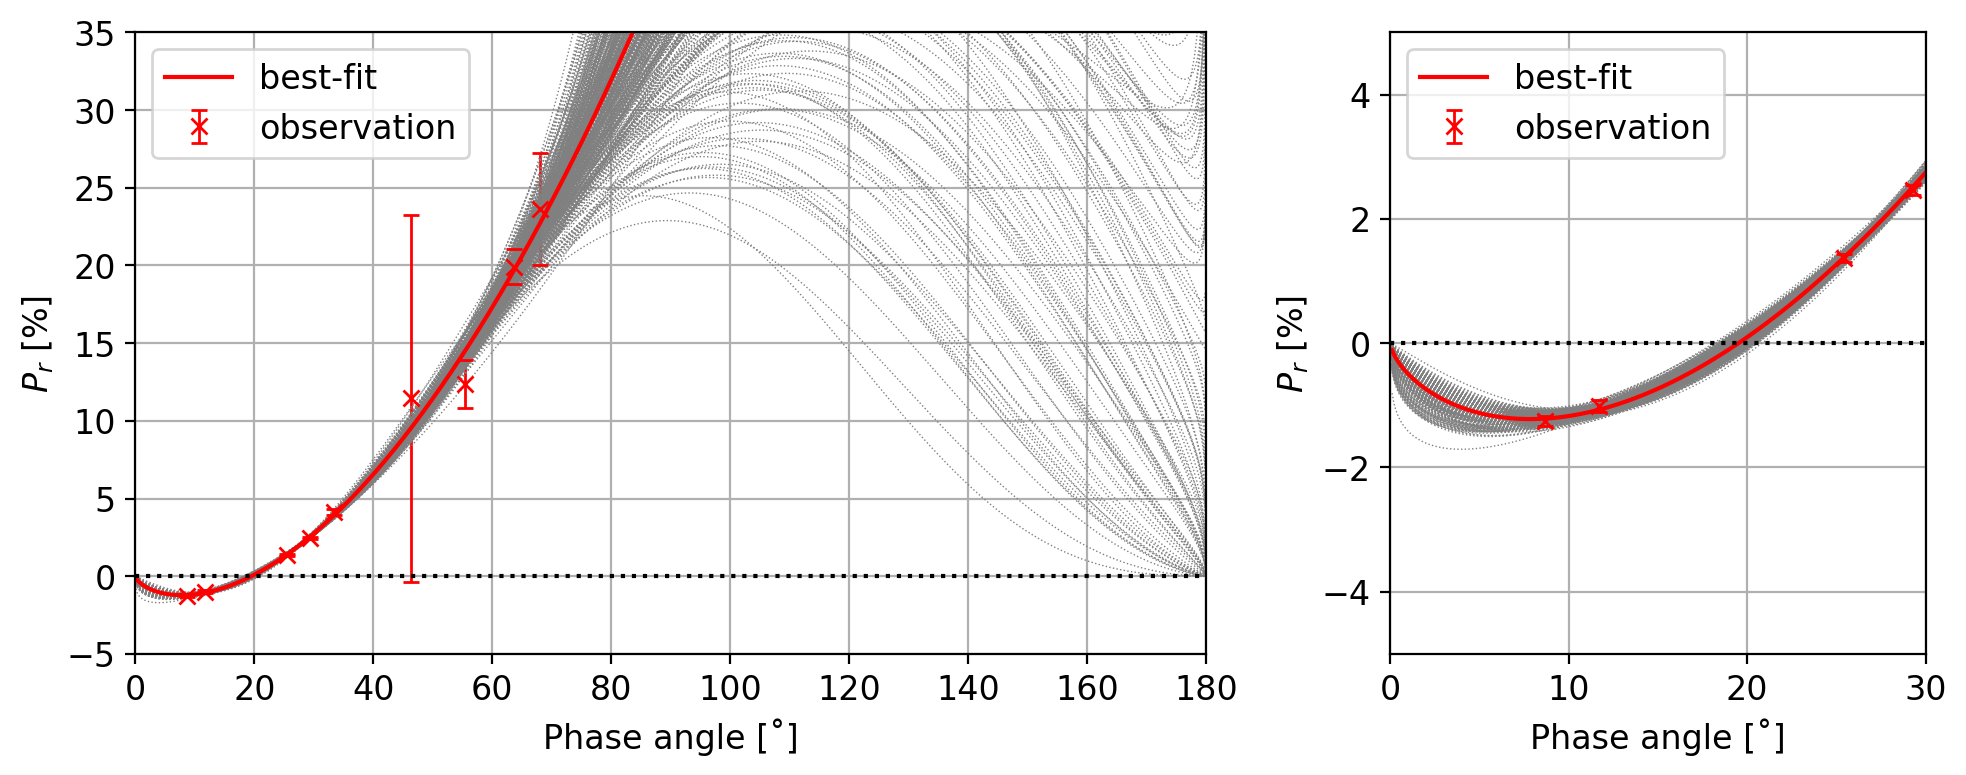

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False, 
                        gridspec_kw={'width_ratios':[2,1]})

majloc = [MultipleLocator(30), MultipleLocator(10)]
minloc = [MultipleLocator(10), MultipleLocator(2)]
majfmt = [FormatStrFormatter("%d"), FormatStrFormatter("%d")]


for ax in axs.tolist():
    for j in range(0, n_trace, 200):
        ax.plot(xx, trigp_purepython(xx, res["h"][j], res["c1"][j], res["c2"][j], res["a0"][j]), 
                 ls=':', lw=0.5, color='grey')

    ax.errorbar(x, y, yerr, marker='x', elinewidth=1, capsize=3, color='r', ls='',
                label="observation")
    ax.plot(xx, trigp_purepython(xx, *popt), color='r', label="best-fit")

    ax.set_xlabel("Phase angle [˚]")
    ax.set_ylabel(r"$ P_r $ [%]")
    ax.legend(loc=2)
    ax.axhline(0, color='k', ls=':')

#     for i, aa in enumerate([ax.xaxis, ax.yaxis]):
#         aa.set_major_locator(majloc[i])
#         aa.set_minor_locator(minloc[i])
#         aa.set_major_formatter(majfmt[i])
    ax.grid(which='major', ls='-')
    ax.grid(which='minor', ls=':')

axs[0].set_xlim(0, 180)
axs[0].set_ylim(-5, 35)
axs[1].set_xlim(0, 30)
axs[1].set_ylim(-5, 5)



plt.tight_layout()
plt.savefig(SAVEPATH / "observation-mcmc-nobound.png", dpi=300)
plt.savefig(SAVEPATH / "observation-mcmc-nobound.pdf")

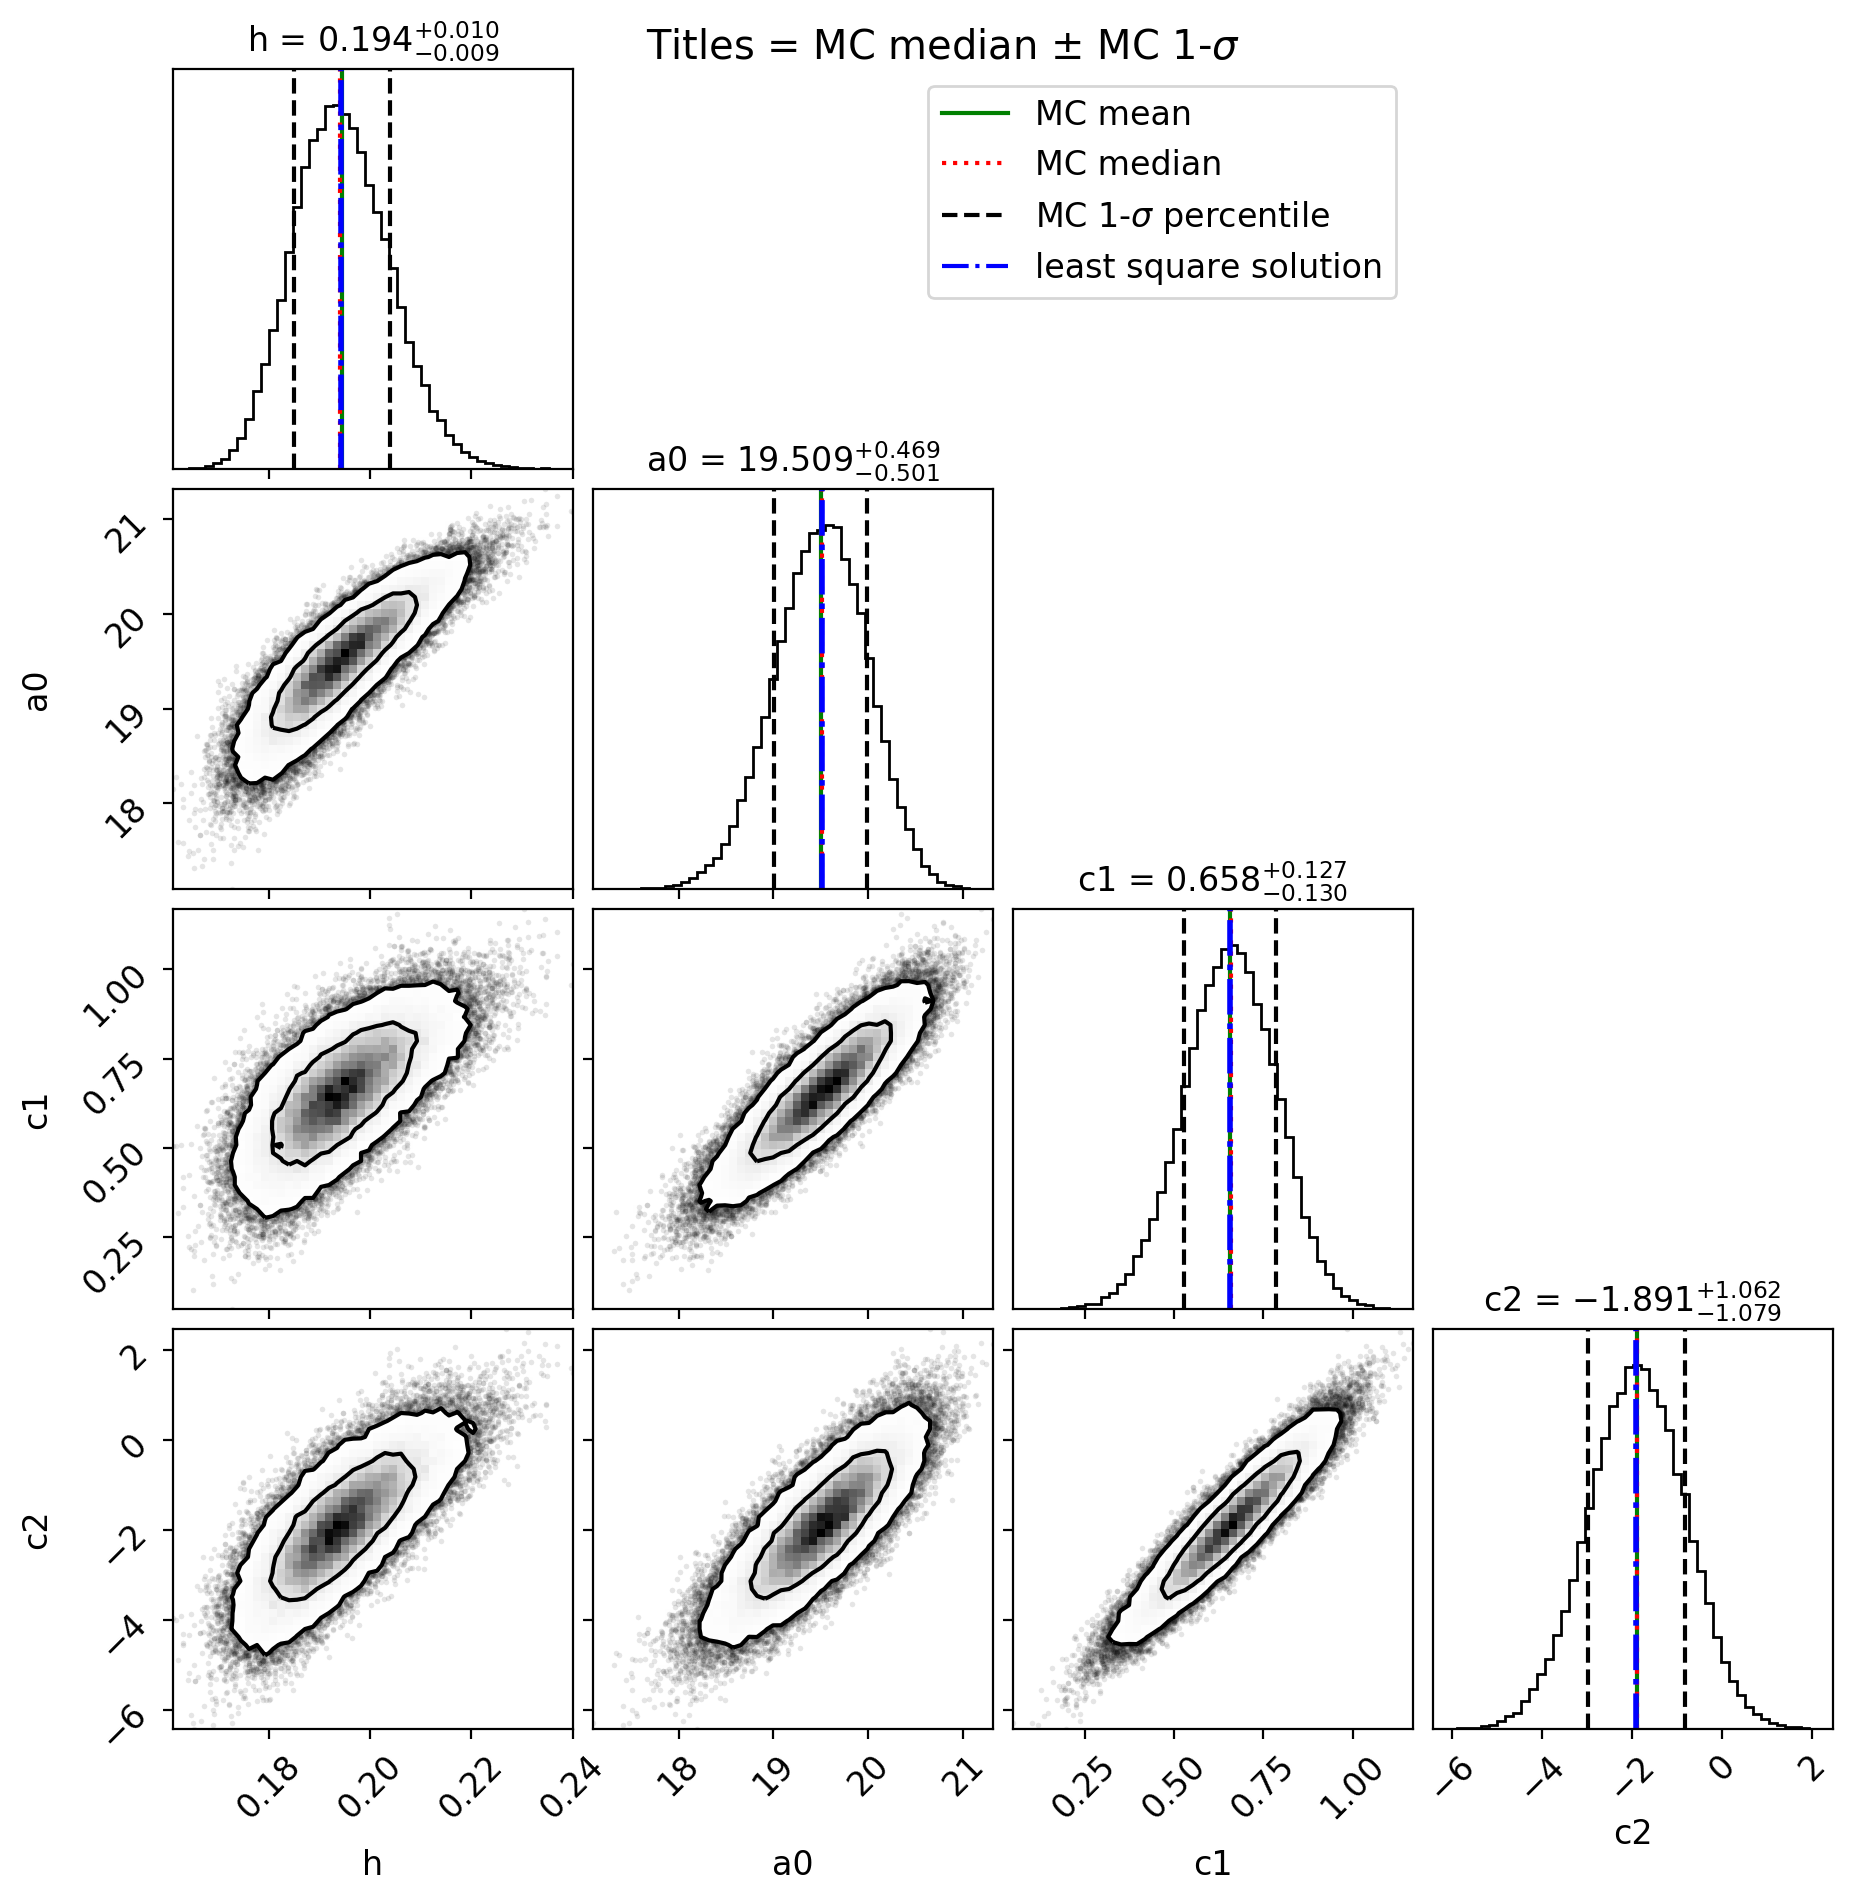

In [27]:
trace_df = pm.trace_to_dataframe(trace)
means = np.mean(trace_df, axis=0)
meds = np.median(trace_df, axis=0)
maps = np.array([popt[0], popt[3], popt[1], popt[2]])

fig = corner.corner(trace_df, 
                    quantiles=[0.5 - 0.6827/2, 0.5 + 0.6827/2],
                    levels=[0.6827, 0.9545], #, 0.9973
                    bins=50,
                    show_titles=True,
                    title_fmt='5.3f',
                    title_kwargs={'fontsize': 12}
                   )
axes = np.array(fig.axes).reshape((4, 4))

# Loop over the diagonal
for i in range(4):
    ax = axes[i, i]
    ax.axvline(means[i], color="g", ls='-')
    ax.axvline(meds[i], color="r", ls=':')
    ax.axvline(maps[i], color='b', ls='-.', lw=2)

axes[0, 2].plot(np.nan, np.nan, 'g-', label='MC mean')
axes[0, 2].plot(np.nan, np.nan, 'r:', label='MC median')
axes[0, 2].plot(np.nan, np.nan, 'k--', label='MC 1-$\sigma$ percentile')
axes[0, 2].plot(np.nan, np.nan, 'b-.', label='least square solution')
axes[0, 2].legend()
        
fig.suptitle("Titles = MC median ± MC 1-$\sigma$")
plt.savefig("corner-nobound.pdf")
plt.savefig("corner-nobound.png", dpi=300)

In [28]:
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was finished at {now} ")

This notebook was finished at 2020-02-15 13:33:00 (KST = GMT+0900) 
